In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, StratifiedKFold
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from skforecast.Sarimax import Sarimax
%matplotlib inline

In [2]:
#models to explore, rbf neural network,  m-estimator based rbf, backprop nn, lstm rnn, look at support basis vector, nadaraya-watson, 
#gaussian process regressor

In [3]:
'''need to figure out when to start my analysis from, ideas could either be 1. at the start of volcker's tenure 2. after volcker got 
inflation under control in late 1982-1983 3. during greenspan's tenure 8/11/1987 '''

"need to figure out when to start my analysis from, ideas could either be 1. at the start of volcker's tenure 2. after volcker got \ninflation under control in late 1982-1983 3. during greenspan's tenure 8/11/1987 "

In [4]:
#need to select features to use 

In [5]:
#need to find some way to account for the zero lower bound

In [6]:
#need to check for stationary and autocorrelation

In [7]:
#features to check out, GDP, Inflation, yield curve, unemployment rate, industrial production, PCE (might be too 
#collinear with other indicators to be useful), retail sales, oil prices, Euro to dollar exchange rate, yen to dollar exchange rate, 
# m2, velocity of m2, real disposable personal income, imports, exports, recession status, nasdaq (maybe), price of gold 

In [8]:
#want to factor in the taylor rule in some way

In [9]:
oil_df = pd.read_csv('../data/Brent_oil.csv')
pce_df = pd.read_csv('../data/chained_pce.csv')
dis_inc_df = pd.read_csv('../data/dispos_income.csv')
export_df = pd.read_csv('../data/exports.csv')
ffr_1_df = pd.read_csv('../data/fed_funds_1.csv')
ffr_2_df = pd.read_csv('../data/fed_funds_2.csv')
gdp_gap_df = pd.read_csv('../data/gdp_gap.csv')
gdp_df = pd.read_csv('../data/GDP.csv')
import_df = pd.read_csv('../data/imports.csv')
ind_prod_df = pd.read_csv('../data/industrial_prod.csv')
m2_df = pd.read_csv('../data/M2.csv')
m2_velo_df = pd.read_csv('../data/M2_velo.csv')
nasdaq_df = pd.read_csv('../data/NASDAQ.csv')
pci_df = pd.read_csv('../data/PCI.csv')
pound_dollar_df = pd.read_csv('../data/pound_dollar.csv')
recession_df = pd.read_csv('../data/recession.csv')
unemployment_df = pd.read_csv('../data/unemployment.csv')
yen_dollar_df = pd.read_csv('../data/yen_to_dollar.csv')
yield_curve_df = pd.read_csv('../data/yield_curve.csv')

In [10]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9525 entries, 0 to 9524
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          9525 non-null   object
 1   DCOILBRENTEU  9525 non-null   object
dtypes: object(2)
memory usage: 149.0+ KB


In [11]:
#daily no weekends
oil_df['DATE'] = pd.to_datetime(oil_df['DATE'])
oil_df.head()

,DATE,DCOILBRENTEU
0,1987-08-11,19.45
1,1987-08-12,19.50
2,1987-08-13,19.40
3,1987-08-14,19.25
4,1987-08-17,18.85


In [12]:
#quarterly
pce_df['DATE'] = pd.to_datetime(pce_df['DATE'])
pce_df.head()

,DATE,DPCCRV1Q225SBEA
0,1987-07-01,3.6
1,1987-10-01,4.1
2,1988-01-01,3.9
3,1988-04-01,4.9
4,1988-07-01,4.7


In [13]:
#monthly
dis_inc_df['DATE'] = pd.to_datetime(dis_inc_df['DATE'])
dis_inc_df.head()

,DATE,DSPIC96
0,1987-08-01,6574.0
1,1987-09-01,6575.3
2,1987-10-01,6619.6
3,1987-11-01,6648.1
4,1987-12-01,6711.5


In [14]:
#quarterly
export_df['DATE'] = pd.to_datetime(export_df['DATE'])
export_df.head()

,DATE,EXPGS
0,1987-07-01,371.854
1,1987-10-01,392.107
2,1988-01-01,418.727
3,1988-04-01,439.471
4,1988-07-01,453.586


In [16]:
#daily
ffr_2_df.head(8)
ffr_2_df = ffr_2_df.rename(columns={"Date": "Date", "DFEDTARU": "DFEDTAR"})
ffr_2_df.head()

,DATE,DFEDTAR
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-20,0.25


In [17]:
#quarterly
gdp_gap_df['DATE'] = pd.to_datetime(gdp_gap_df['DATE'])
gdp_gap_df.head()

,DATE,GDPC1_GDPPOT
0,1987-07-01,-1.196214
1,1987-10-01,-0.293283
2,1988-01-01,-0.559415
3,1988-04-01,-0.037442
4,1988-07-01,-0.230370


In [18]:
#quarterly
gdp_df['DATE'] = pd.to_datetime(gdp_df['DATE'])
gdp_df.head()

,DATE,GDP
0,1987-07-01,4884.555
1,1987-10-01,5007.994
2,1988-01-01,5073.372
3,1988-04-01,5190.036
4,1988-07-01,5282.835


In [19]:
# quarterly 
import_df['DATE'] = pd.to_datetime(import_df['DATE'])
import_df.head()

,DATE,IMPGS
0,1987-07-01,517.318
1,1987-10-01,537.511
2,1988-01-01,542.714
3,1988-04-01,546.098
4,1988-07-01,552.849


In [20]:
#monthly 
ind_prod_df['DATE'] = pd.to_datetime(ind_prod_df['DATE'])
ind_prod_df.head()

,DATE,INDPRO
0,1987-08-01,58.6889
1,1987-09-01,58.9137
2,1987-10-01,59.7083
3,1987-11-01,60.0022
4,1987-12-01,60.3336


In [21]:
#weekly
m2_df['DATE'] = pd.to_datetime(m2_df['DATE'])
m2_df.head()

,DATE,WM2NS
0,1987-08-17,2792.5
1,1987-08-24,2780.3
2,1987-08-31,2778.2
3,1987-09-07,2801.9
4,1987-09-14,2807.3


In [22]:
#quarterly
m2_velo_df['DATE'] = pd.to_datetime(m2_velo_df['DATE'])
m2_velo_df.head()

,DATE,M2V
0,1987-07-01,1.751
1,1987-10-01,1.776
2,1988-01-01,1.768
3,1988-04-01,1.774
4,1988-07-01,1.790


In [23]:
#daily no weekends
nasdaq_df['DATE'] = pd.to_datetime(nasdaq_df['DATE'])
nasdaq_df.head()

,DATE,NASDAQCOM
0,1987-08-11,449.36
1,1987-08-12,449.23
2,1987-08-13,451.55
3,1987-08-14,451.61
4,1987-08-17,451.65


In [24]:
#monthly
pci_df['DATE'] = pd.to_datetime(pci_df['DATE'])
pci_df.head()

,DATE,CORESTICKM159SFRBATL
0,1987-08-01,4.293051
1,1987-09-01,4.305931
2,1987-10-01,4.356982
3,1987-11-01,4.329616
4,1987-12-01,4.291749


In [25]:
#daily no weekends
pound_dollar_df['DATE'] = pd.to_datetime(pound_dollar_df['DATE'])
pound_dollar_df.head()

,DATE,DEXUSUK
0,1987-08-11,1.5697
1,1987-08-12,1.5790
2,1987-08-13,1.5797
3,1987-08-14,1.5890
4,1987-08-17,1.5908


In [26]:
#monthly
recession_df['DATE'] = pd.to_datetime(recession_df['DATE'])
recession_df.head()

,DATE,RECPROUSM156N
0,1987-08-01,0.04
1,1987-09-01,0.00
2,1987-10-01,0.00
3,1987-11-01,0.02
4,1987-12-01,0.06


In [27]:
#monthly
unemployment_df['DATE'] = pd.to_datetime(unemployment_df['DATE'])
unemployment_df.head()

,DATE,UNRATE
0,1987-08-01,6.0
1,1987-09-01,5.9
2,1987-10-01,6.0
3,1987-11-01,5.8
4,1987-12-01,5.7


In [28]:
#daily no weekends
yen_dollar_df['DATE'] = pd.to_datetime(yen_dollar_df['DATE'])
yen_dollar_df.head()

,DATE,DEXJPUS
0,1987-08-11,151.77
1,1987-08-12,151.25
2,1987-08-13,151.45
3,1987-08-14,150.00
4,1987-08-17,149.92


In [29]:
yield_curve_df['DATE'] = pd.to_datetime(yield_curve_df['DATE'])
yield_curve_df.head()

,DATE,T10Y2Y
0,1987-08-11,1.04
1,1987-08-12,1.05
2,1987-08-13,0.99
3,1987-08-14,0.96
4,1987-08-17,0.94


In [30]:
ffr_df = pd.concat([ffr_1_df, ffr_2_df], ignore_index=True)
ffr_df.head()

,DATE,DFEDTAR
0,1987-08-11,6.625
1,1987-08-12,6.625
2,1987-08-13,6.625
3,1987-08-14,6.625
4,1987-08-15,6.625


In [31]:
ffr_df.info()
ffr_df = ffr_df.rename(columns={"DATE": "DATE", "DFEDTAR": "FFTR"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13344 entries, 0 to 13343
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     13344 non-null  object 
 1   DFEDTAR  13344 non-null  float64
dtypes: float64(1), object(1)
memory usage: 208.6+ KB


In [32]:
#need to change this to datetime object after joining dataframes
type(ffr_df['DATE'][1])

str

In [33]:
ffr_df['DATE'] = pd.to_datetime(ffr_df['DATE'])

In [34]:
type(unemployment_df['DATE'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [35]:
test_merge_df = ffr_df.merge(unemployment_df, left_on='DATE', right_on='DATE')
test_merge_df.head()

,DATE,FFTR,UNRATE
0,1987-09-01,6.7500,5.9
1,1987-10-01,7.3125,6.0
2,1987-11-01,7.3125,5.8
3,1987-12-01,6.8125,5.7
4,1988-01-01,6.8125,5.7


In [36]:
test_merge_df = pd.merge_ordered(ffr_df, unemployment_df, fill_method="none", left_by="DATE")
test_merge_df.head(31)

,DATE,FFTR,UNRATE
0,1987-08-11,6.625,NaN
1,1987-08-12,6.625,NaN
2,1987-08-13,6.625,NaN
3,1987-08-14,6.625,NaN
4,1987-08-15,6.625,NaN
5,1987-08-16,6.625,NaN
6,1987-08-17,6.625,NaN
7,1987-08-18,6.625,NaN
8,1987-08-19,6.625,NaN
9,1987-08-20,6.625,NaN


In [37]:
test_merge_df['UNRATE'] = test_merge_df['UNRATE'].interpolate(method='linear', limit_direction= 'both', axis=0)
test_merge_df.head(31)

,DATE,FFTR,UNRATE
0,1987-08-11,6.625,5.900000
1,1987-08-12,6.625,5.900000
2,1987-08-13,6.625,5.900000
3,1987-08-14,6.625,5.900000
4,1987-08-15,6.625,5.900000
5,1987-08-16,6.625,5.900000
6,1987-08-17,6.625,5.900000
7,1987-08-18,6.625,5.900000
8,1987-08-19,6.625,5.900000
9,1987-08-20,6.625,5.900000


In [38]:
#that shouldnt be a string, changing it
type(oil_df['DCOILBRENTEU'][1])

str

In [39]:
oil_df = oil_df.rename(columns={"DATE": "DATE", "DCOILBRENTEU": "Oil"})
merge_df = pd.merge_ordered(test_merge_df, oil_df, fill_method="none", left_by="DATE")
merge_df['Oil'] = merge_df['Oil'].replace('.', np.nan)
merge_df['Oil'] = merge_df['Oil'].astype(float)
merge_df['Oil'] = merge_df['Oil'].interpolate(method='linear',  axis=0)
merge_df.head(31)

,DATE,FFTR,UNRATE,Oil
0,1987-08-11,6.625,5.900000,19.450000
1,1987-08-12,6.625,5.900000,19.500000
2,1987-08-13,6.625,5.900000,19.400000
3,1987-08-14,6.625,5.900000,19.250000
4,1987-08-15,6.625,5.900000,19.116667
5,1987-08-16,6.625,5.900000,18.983333
6,1987-08-17,6.625,5.900000,18.850000
7,1987-08-18,6.625,5.900000,18.750000
8,1987-08-19,6.625,5.900000,18.500000
9,1987-08-20,6.625,5.900000,18.300000


In [40]:
pce_df = pce_df.rename(columns={"DATE": "DATE", "DPCCRV1Q225SBEA": "PCE"})
merge_df = pd.merge_ordered(merge_df, pce_df, fill_method="ffill")
merge_df.head()

,DATE,FFTR,UNRATE,Oil,PCE
0,1987-07-01,NaN,NaN,NaN,3.6
1,1987-08-11,6.625,5.9,19.45,3.6
2,1987-08-12,6.625,5.9,19.50,3.6
3,1987-08-13,6.625,5.9,19.40,3.6
4,1987-08-14,6.625,5.9,19.25,3.6


In [41]:
type(merge_df['PCE'][1])

numpy.float64

In [42]:
dis_inc_df = dis_inc_df.rename(columns={"DATE": "DATE", "DSPIC96": "DispInc"})
merge_df = pd.merge_ordered(merge_df, dis_inc_df, fill_method="ffill")

In [43]:
gdp_gap_df = gdp_gap_df.rename(columns={"DATE": "DATE", "GDPC1_GDPPOT": "gdp_gap"})
merge_df = pd.merge_ordered(merge_df, gdp_gap_df, fill_method="ffill")

In [44]:
merge_df = pd.merge_ordered(merge_df, gdp_df, fill_method="ffill")

In [45]:
test_bug_df = pd.merge_ordered(export_df, import_df, fill_method="ffill", left_by="DATE")

In [46]:
merge_df = pd.merge_ordered(merge_df, test_bug_df, fill_method="ffill")

In [47]:
ind_prod_df = ind_prod_df.rename(columns={"DATE": "DATE", "INDPRO": "ind_prod"})
merge_df = pd.merge_ordered(merge_df, ind_prod_df, fill_method="ffill")

In [48]:
ind_prod_df = ind_prod_df.rename(columns={"DATE": "DATE", "INDPRO": "ind_prod"})
merge_df = pd.merge_ordered(merge_df, ind_prod_df, fill_method="ffill")

In [49]:
m2_df = m2_df.rename(columns={"DATE": "DATE", "WM2NS": "m2"})
merge_df = pd.merge_ordered(merge_df, m2_df, fill_method="none")
merge_df['m2'] = merge_df['m2'].interpolate(method='linear', limit_direction= 'both', axis=0)
merge_df.head()

,DATE,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,m2
0,1987-07-01,NaN,NaN,NaN,3.6,NaN,-1.196214,4884.555,371.854,517.318,NaN,2792.5
1,1987-08-01,NaN,NaN,NaN,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5
2,1987-08-11,6.625,5.9,19.45,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5
3,1987-08-12,6.625,5.9,19.50,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5
4,1987-08-13,6.625,5.9,19.40,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5


In [50]:
m2_velo_df = m2_velo_df.rename(columns={"DATE": "DATE", "M2V": "m2_velo"})
merge_df = pd.merge_ordered(merge_df, m2_velo_df, fill_method="ffill")

In [51]:
nasdaq_df = nasdaq_df.rename(columns={"DATE": "DATE", "NASDAQCOM": "nasdaq"})
merge_df = pd.merge_ordered(merge_df, nasdaq_df, fill_method="none")

In [52]:
pci_df = pci_df.rename(columns={"DATE": "DATE", "CORESTICKM159SFRBATL": "pci"})
merge_df = pd.merge_ordered(merge_df, pci_df, fill_method="ffill")

In [53]:
pound_dollar_df = pound_dollar_df.rename(columns={"DATE": "DATE", "DEXUSUK": "gbp_dollar"})
merge_df = pd.merge_ordered(merge_df, pound_dollar_df, fill_method="none")

In [54]:
recession_df = recession_df.rename(columns={"DATE": "DATE", "RECPROUSM156N": "pct_recession"})
merge_df = pd.merge_ordered(merge_df, recession_df, fill_method="ffill")

In [55]:
yen_dollar_df = yen_dollar_df.rename(columns={"DATE": "DATE", "DEXJPUS": "yen_dollar"})
merge_df = pd.merge_ordered(merge_df, yen_dollar_df, fill_method="none")

In [56]:
yield_curve_df = yield_curve_df.rename(columns={"DATE": "DATE", "T10Y2Y": "yield_curve"})
merge_df = pd.merge_ordered(merge_df, yield_curve_df, fill_method="none")

In [57]:
merge_df = merge_df.iloc[2:]

In [58]:
merge_df = merge_df.set_index('DATE')

In [59]:
merge_df['nasdaq'] = merge_df['nasdaq'].replace('.', np.nan)
merge_df['nasdaq'] = merge_df['nasdaq'].astype(float)
merge_df['nasdaq'] = merge_df['nasdaq'].interpolate(method='linear', limit_direction= 'forward', axis=0)
merge_df['gbp_dollar'] = merge_df['gbp_dollar'].replace('.', np.nan)
merge_df['gbp_dollar'] = merge_df['gbp_dollar'].astype(float)
merge_df['gbp_dollar'] = merge_df['gbp_dollar'].interpolate(method='linear', limit_direction= 'forward', axis=0)
merge_df['yen_dollar'] = merge_df['yen_dollar'].replace('.', np.nan)
merge_df['yen_dollar'] = merge_df['yen_dollar'].astype(float)
merge_df['yen_dollar'] = merge_df['yen_dollar'].interpolate(method='linear', limit_direction= 'forward', axis=0)
merge_df['yield_curve'] = merge_df['yield_curve'].replace('.', np.nan)
merge_df['yield_curve'] = merge_df['yield_curve'].astype(float)
merge_df['yield_curve'] = merge_df['yield_curve'].interpolate(method='linear', limit_direction= 'forward', axis=0)
#merge_df['nasdaq'].fillna()

In [60]:
type(merge_df['nasdaq'][1])

numpy.float64

In [61]:
merge_df.isna().sum()

FFTR             0
UNRATE           0
Oil              0
PCE              0
DispInc          0
gdp_gap          0
GDP              0
EXPGS            0
IMPGS            0
ind_prod         0
m2               0
m2_velo          0
nasdaq           0
pci              0
gbp_dollar       0
pct_recession    0
yen_dollar       0
yield_curve      0
dtype: int64

In [62]:
merge_df['nasdaq'].head(55)

DATE
1987-08-11    449.360000
1987-08-12    449.230000
1987-08-13    451.550000
1987-08-14    451.610000
1987-08-15    451.623333
1987-08-16    451.636667
1987-08-17    451.650000
1987-08-18    446.760000
1987-08-19    447.950000
1987-08-20    452.750000
1987-08-21    455.200000
1987-08-22    454.733333
1987-08-23    454.266667
1987-08-24    453.800000
1987-08-25    455.100000
1987-08-26    455.260000
1987-08-27    454.790000
1987-08-28    453.290000
1987-08-29    453.850000
1987-08-30    454.410000
1987-08-31    454.970000
1987-09-01    452.500000
1987-09-02    448.930000
1987-09-03    448.360000
1987-09-04    446.480000
1987-09-05    444.260000
1987-09-06    442.040000
1987-09-07    439.820000
1987-09-08    437.600000
1987-09-09    439.190000
1987-09-10    443.480000
1987-09-11    446.170000
1987-09-12    445.943333
1987-09-13    445.716667
1987-09-14    445.490000
1987-09-15    441.940000
1987-09-16    440.850000
1987-09-17    440.750000
1987-09-18    440.860000
1987-09-19    439.24

In [63]:
tss = TimeSeriesSplit(n_splits = 3)
X = merge_df.drop(columns=['FFTR'])
y = merge_df['FFTR']

In [64]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [65]:
#1st need to decompose FFTR and find the best p and q values for SARIMAX, 

In [66]:
X_train.head()

,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,m2,m2_velo,nasdaq,pci,gbp_dollar,pct_recession,yen_dollar,yield_curve
DATE,,,,,,,,,,,,,,,,,
1987-08-11,5.9,19.450000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,449.360000,4.293051,1.5697,0.04,151.770000,1.040000
1987-08-12,5.9,19.500000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,449.230000,4.293051,1.5790,0.04,151.250000,1.050000
1987-08-13,5.9,19.400000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,451.550000,4.293051,1.5797,0.04,151.450000,0.990000
1987-08-14,5.9,19.250000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,451.610000,4.293051,1.5890,0.04,150.000000,0.960000
1987-08-15,5.9,19.116667,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,451.623333,4.293051,1.5896,0.04,149.973333,0.953333


Test stationarity for original series
-------------------------------------


/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_10929/1681230618.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(y)


ADF Statistic: -1.4781570378839006, p-value: 0.544287744795731
KPSS Statistic: 10.337427480811384, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------


/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_10929/1681230618.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(y.diff().dropna())


ADF Statistic: -13.783922954191008, p-value: 9.18710879732297e-26
KPSS Statistic: 0.7515215106299452, p-value: 0.01

Test stationarity for differenced series (order=2)
--------------------------------------------------


/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_10929/1681230618.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(y.diff().diff().dropna())


ADF Statistic: -28.053071562566572, p-value: 0.0
KPSS Statistic: 0.010605606355868701, p-value: 0.1


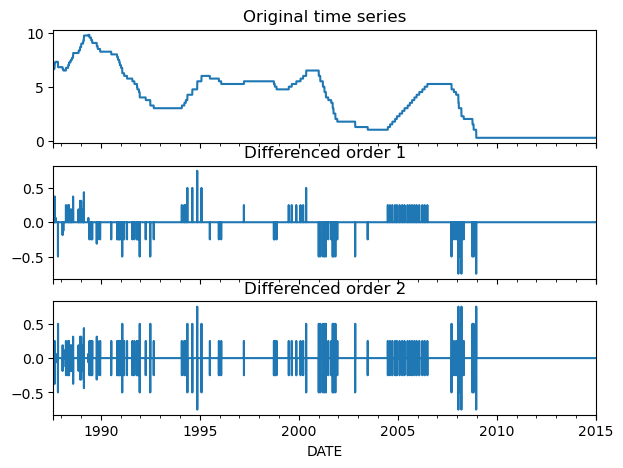

In [67]:
# Test stationarity
# ==============================================================================

data_diff_1 = y_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(y)
kpss_result = kpss(y)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(y.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(y.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')


# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
y.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

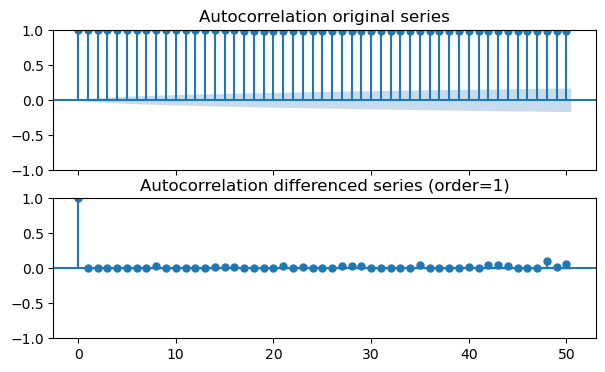

In [68]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(y, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');

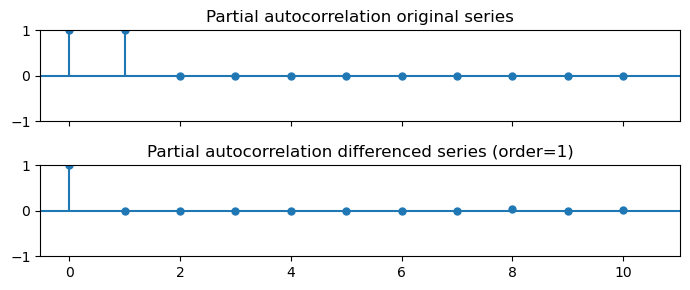

In [69]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(y, ax=axs[0], lags=10, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=10, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();


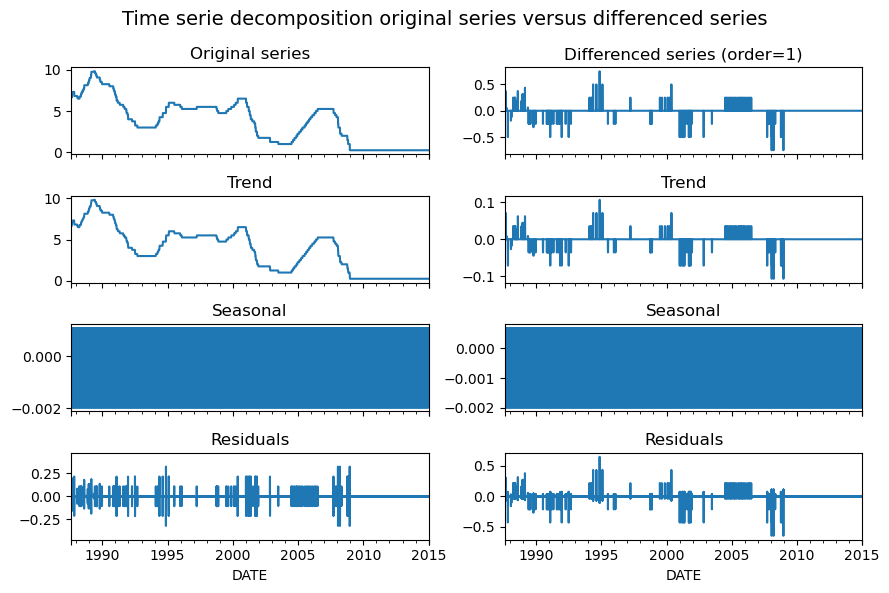

In [70]:
res_decompose = seasonal_decompose(y, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

In [71]:
# d value is 1, p is 1, q is 1, seasonality is 5.5 years, D = 0, 

In [72]:
#exog = X_train
#model = SARIMAX(endog = y_train, order = (1, 1, 1), seasonal_order = (1, 0, 1, 2008))
#model_res = model.fit(disp=0)
#warnings.filterwarnings("default")

#model_res.summary()

In [73]:
#this takes way too long, need to trim feature space

In [74]:
month_df = merge_df.resample('M')

In [75]:
merge_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,m2,m2_velo,nasdaq,pci,gbp_dollar,pct_recession,yen_dollar,yield_curve
DATE,,,,,,,,,,,,,,,,,,
1987-08-11,6.625,5.9,19.450000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,449.360000,4.293051,1.5697,0.04,151.770000,1.040000
1987-08-12,6.625,5.9,19.500000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,449.230000,4.293051,1.5790,0.04,151.250000,1.050000
1987-08-13,6.625,5.9,19.400000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,451.550000,4.293051,1.5797,0.04,151.450000,0.990000
1987-08-14,6.625,5.9,19.250000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,451.610000,4.293051,1.5890,0.04,150.000000,0.960000
1987-08-15,6.625,5.9,19.116667,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,1.751,451.623333,4.293051,1.5896,0.04,149.973333,0.953333


In [76]:
merge_df['1_month_ahead'] = merge_df['FFTR'].shift(periods=30)
merge_df['2_month_ahead'] = merge_df['FFTR'].shift(periods=60)
merge_df['3_month_ahead'] = merge_df['FFTR'].shift(periods=90)
merge_df['1_month_back'] = merge_df['FFTR'].shift(periods=-30)
merge_df['2_month_back'] = merge_df['FFTR'].shift(periods=-60)
merge_df['3_month_back'] = merge_df['FFTR'].shift(periods=-90)
merge_df = merge_df.iloc[90:]
merge_df = merge_df.drop(merge_df.tail(90).index)

In [77]:
merge_df.to_csv('../data/merged_fftr.csv', index=True)

In [78]:
month_df = merge_df.groupby(pd.DatetimeIndex(merge_df.index).to_period('M')).nth(0)
month_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,gbp_dollar,pct_recession,yen_dollar,yield_curve,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back
DATE,,,,,,,,,,,,,,,,,,,,,
1987-11-09,6.8125,5.773333,17.5000,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.793000,0.02,134.3000,1.14,7.3125,7.2500,6.6250,6.8125,6.8125,6.625
1987-12-01,6.8125,5.700000,17.6500,4.1,6711.5,-0.293283,5007.994,392.107,537.511,60.3336,...,1.818000,0.06,133.0000,1.24,7.3125,7.3125,6.7500,6.8125,6.6250,6.500
1988-01-01,6.8125,5.700000,17.6875,3.9,6730.2,-0.559415,5073.372,418.727,542.714,60.3186,...,1.883825,0.36,121.6125,1.06,6.8125,7.3125,7.3125,6.6250,6.5000,6.750
1988-02-01,6.6250,5.700000,16.1000,3.9,6773.5,-0.559415,5073.372,418.727,542.714,60.6209,...,1.758000,0.00,129.3800,1.04,6.8125,6.8125,7.3125,6.5000,6.7500,6.750
1988-03-01,6.5000,5.700000,14.1800,3.9,6804.3,-0.559415,5073.372,418.727,542.714,60.7591,...,1.777500,0.00,128.2700,1.04,6.6250,6.8125,6.8125,6.7500,6.7500,7.250


In [79]:
month_df['1_month_ahead'] = month_df['FFTR'].shift(periods=1)
month_df['2_month_ahead'] = month_df['FFTR'].shift(periods=2)
month_df['3_month_ahead'] = month_df['FFTR'].shift(periods=3)
month_df['1_month_back'] = month_df['FFTR'].shift(periods=-1)
month_df['2_month_back'] = month_df['FFTR'].shift(periods=-2)
month_df['3_month_back'] = month_df['FFTR'].shift(periods=-3)
month_df = month_df.iloc[3:]
month_df = month_df.drop(month_df.tail(3).index)

/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_10929/53275203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df['1_month_ahead'] = month_df['FFTR'].shift(periods=1)
/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_10929/53275203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df['2_month_ahead'] = month_df['FFTR'].shift(periods=2)
/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_10929/53275203.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [80]:
month_df.to_csv('../data/monthly_data.csv', index=True)

In [82]:
month_df = month_df.iloc[3:]

In [83]:
tss = TimeSeriesSplit(n_splits = 5)
X_month = month_df.drop(columns=['3_month_ahead'])
y_month = month_df['3_month_ahead']

In [84]:
for train_index, test_index in tss.split(X_month):
    X_train_month, X_test_month = X_month.iloc[train_index, :], X_month.iloc[test_index,:]
    y_train_month, y_test_month = y_month.iloc[train_index], y_month.iloc[test_index]

In [85]:
#model = SARIMAX(endog = y_train_month, exog = X_train_month, order = (1, 1, 1), seasonal_order = (1, 0, 1, 83))
#model_res = model.fit(disp=0)
#warnings.filterwarnings("default")

In [86]:
merge_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,gbp_dollar,pct_recession,yen_dollar,yield_curve,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back
DATE,,,,,,,,,,,,,,,,,,,,,
1987-11-09,6.8125,5.773333,17.50,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7930,0.02,134.30,1.140,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-10,6.8125,5.770000,17.75,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7865,0.02,134.55,1.180,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-11,6.8125,5.766667,17.80,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7720,0.02,135.50,1.155,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-12,6.8125,5.763333,17.85,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7575,0.02,136.45,1.130,7.3125,7.25,6.625,6.8125,6.8125,6.625
1987-11-13,6.8125,5.760000,17.80,4.1,6648.1,-0.293283,5007.994,392.107,537.511,60.0022,...,1.7680,0.02,135.85,1.090,7.3125,7.25,6.625,6.8125,6.8125,6.500


In [87]:
month_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,pct_recession,yen_dollar,yield_curve,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back,3_month_rate
DATE,,,,,,,,,,,,,,,,,,,,,
1988-05-01,6.7500,5.6,16.166667,4.9,6841.7,-0.037442,5190.036,439.471,546.098,60.9952,...,0.12,124.94,1.153333,6.7500,6.50,6.625,7.2500,7.5000,7.6875,6.625
1988-06-01,7.2500,5.4,16.330000,4.9,6868.5,-0.037442,5190.036,439.471,546.098,61.1697,...,0.00,125.20,0.940000,6.7500,6.75,6.500,7.5000,7.6875,8.1250,6.500
1988-07-01,7.5000,5.4,13.950000,4.7,6898.2,-0.230370,5282.835,453.586,552.849,61.1749,...,0.06,134.10,0.790000,7.2500,6.75,6.750,7.6875,8.1250,8.1250,6.750
1988-08-01,7.6875,5.6,15.600000,4.7,6918.4,-0.230370,5282.835,453.586,552.849,61.4851,...,0.04,132.80,0.710000,7.5000,7.25,6.750,8.1250,8.1250,8.1250,6.750
1988-09-01,8.1250,5.4,14.150000,4.7,6932.4,-0.230370,5282.835,453.586,552.849,61.2844,...,0.02,136.35,0.570000,7.6875,7.50,7.250,8.1250,8.1250,8.3750,7.250


In [89]:
#using regular train test split for rfecv because if i used time series split i would have bad validation scores because of how TSS works
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_month, y_month, random_state=42, test_size=0.25)

In [90]:
def run_model(model, X_train, X_test, y_train, y_test, display=True):
    
    train_r2 = model.score(X_train_rfe, y_train_rfe)
    y_pred_train = model.predict(X_train_rfe)
    train_rmse = mean_squared_error(y_train_rfe, y_pred_train, squared=False)
    
    test_r2 = model.score(X_test_rfe, y_test_rfe)
    y_pred_test = model.predict(X_test_rfe)
    test_rmse = mean_squared_error(y_test_rfe, y_pred_test, squared=False)
    
    if (display):
        print('Training R^2:', train_r2)
        print('Training Root Mean Squared Error:', train_rmse)
        print('\n----------------\n')
        print('Testing R^2:', test_r2)
        print('Testing Root Mean Squared Error:', test_rmse)
        
    return test_r2, test_rmse

In [91]:
lr = LinearRegression()
lr.fit(X_train_rfe, y_train_rfe)
poly_r2, poly_rmse = run_model(lr, X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe)

Training R^2: 1.0
Training Root Mean Squared Error: 4.4142954385473183e-14

----------------

Testing R^2: 1.0
Testing Root Mean Squared Error: 4.6635659619107564e-14


In [92]:
rfe_cv = RFECV(LinearRegression(), cv=10)
X_rfe_train = rfe_cv.fit_transform(X_train_rfe, y_train_rfe)
X_rfe_test = rfe_cv.transform(X_test_rfe)
lr = LinearRegression()
lr.fit(X_train_rfe, y_train_rfe)

rfe_r2, rfe_rmse = run_model(lr, X_rfe_train, X_rfe_test, y_train_rfe, y_test_rfe)
print('\n----------------\n')
print(f"{X_rfe_train.shape[1]} out of {X_train_rfe.shape[1]} features used")
print('Baseline R-Squared:', round(poly_r2, 4))
print('Reduced R-Squared: ', round(rfe_r2, 4))

Training R^2: 1.0
Training Root Mean Squared Error: 4.4142954385473183e-14

----------------

Testing R^2: 1.0
Testing Root Mean Squared Error: 4.6635659619107564e-14

----------------

1 out of 24 features used
Baseline R-Squared: 1.0
Reduced R-Squared:  1.0


In [93]:
select = RFECV(estimator=LinearRegression(), cv=5)
select = select.fit(X_month, y_month)
print("Feature ranking: ", select.ranking_)

Feature ranking:  [17  5  9 10 22  4 21 15 16 19 24 14 23  6  2 20  8 12 18  3  1 11 13  7]


In [94]:
# this means all of our feartures mean something, might try pca to reduce feature set

In [95]:
month_df_reduced = month_df.iloc[100:]
month_df_reduced.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,...,pct_recession,yen_dollar,yield_curve,1_month_ahead,2_month_ahead,3_month_ahead,1_month_back,2_month_back,3_month_back,3_month_rate
DATE,,,,,,,,,,,,,,,,,,,,,
1996-12-01,5.25,5.4,23.390000,2.3,8533.1,0.734551,8259.771,903.798,992.620,77.3731,...,0.02,113.826667,0.470000,5.25,5.25,5.25,5.25,5.25,5.25,5.25
1997-01-01,5.25,5.3,24.175000,1.6,8556.4,0.503962,8362.655,918.374,1027.213,77.5138,...,0.00,115.630000,0.560000,5.25,5.25,5.25,5.25,5.25,5.50,5.25
1997-02-01,5.25,5.2,23.156667,1.6,8579.2,0.503962,8362.655,918.374,1027.213,78.4246,...,0.00,121.393333,0.586667,5.25,5.25,5.25,5.25,5.50,5.50,5.25
1997-03-01,5.25,5.2,19.326667,1.6,8619.0,0.503962,8362.655,918.374,1027.213,78.9266,...,0.00,120.936667,0.470000,5.25,5.25,5.25,5.50,5.50,5.50,5.25
1997-04-01,5.50,5.1,18.150000,2.1,8624.5,1.251815,8518.825,954.450,1039.651,78.9924,...,0.00,122.700000,0.480000,5.25,5.25,5.25,5.50,5.50,5.50,5.25


In [96]:
tss = TimeSeriesSplit(n_splits = 5)
X_month_reduced = month_df_reduced.drop(columns=['FFTR', '3_month_ahead'])
y_month_reduced = month_df_reduced['FFTR']

In [97]:
for train_index, test_index in tss.split(X_month_reduced):
    X_train_month_red, X_test_month_red = X_month_reduced.iloc[train_index, :], X_month_reduced.iloc[test_index,:]
    y_train_month_red, y_test_month_red = y_month_reduced.iloc[train_index], y_month_reduced.iloc[test_index]

In [98]:
model = SARIMAX(endog = y_train_month_red, exog = X_train_month_red, order = (1, 1, 1), trend = 'n', seasonal_order = (1, 0, 1, 83))
model_res = model.fit(disp=0)

/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


KeyboardInterrupt: 

In [ ]:
model_res.summary()

In [ ]:
#best params are (1,1,1) (1,1,1,83)

In [ ]:
steps = [('sarimax', Sarimax(order = (1, 1, 1), seasonal_order = (1, 0, 1, 83)))]
pipe = Pipeline(steps)
params = {'sarimax__order': [(1, 1, 1)] ,
          'sarimax__seasonal_order': [(1, 1, 1, 83), (0, 1, 0, 83), (1, 1, 1, 83), (0,1,1,83)],
         'sarimax__trend': ['n', 'c']}
sarimax_cv = GridSearchCV(estimator = pipe, param_grid = params, cv = 5)

In [ ]:
sarimax_cv.fit(y_train_month_red, X_train_month_red)

In [ ]:
sarimax_cv.best_params_

In [ ]:
best_serimax_model = sarimax_cv.best_estimator_

In [ ]:
best_serimax_model

In [ ]:
predictions_statsmodels = model_res.get_forecast(steps=len(y_test_month_red), exog = X_test_month_red).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
display(predictions_statsmodels.head(25))

In [ ]:
y_test_month_red.head(25)

In [ ]:
#tomorrow make a correlation heatmap and look for ways to apply a cost function, if not then sarimax wont work well due to us trying to 